### Imports

In [1]:
import sys
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
from scvi.model import SCANVI
import gseapy as gp
import seaborn as sns

from bioinfokit import analys, visuz

Global seed set to 0


### Open data

In [2]:
datam = sc.read_10x_h5('/beegfs/v0/bruening_group/CCG/2023-04-corinna-snseq/11042023/cellranger/agg/outs/count/filtered_feature_bc_matrix.h5')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 119444 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

### Preprocessing

In [9]:
sc.pp.filter_cells(datam, min_genes=200) 
sc.pp.filter_genes(datam, min_cells=3) 

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
datam.var['mt'] = datam.var.index.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(datam, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

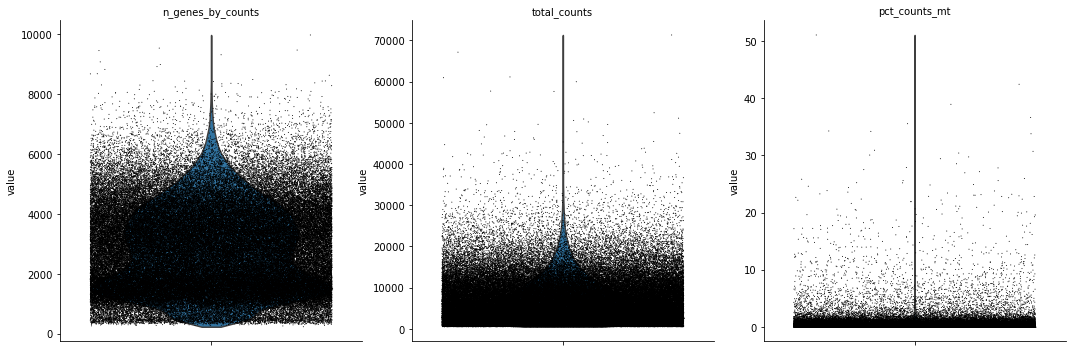

In [12]:
sc.pl.violin(datam, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

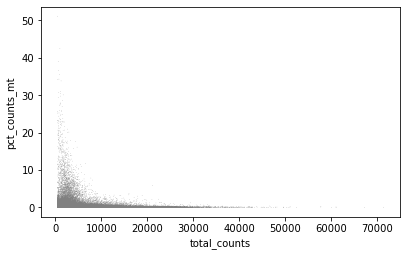

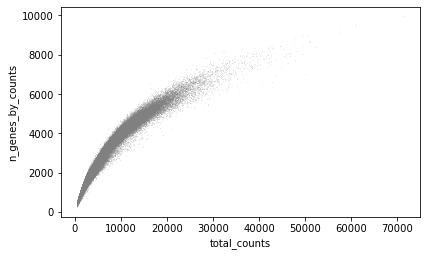

In [13]:
sc.pl.scatter(datam, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(datam, x='total_counts', y='n_genes_by_counts')

In [14]:
datam = datam[datam.obs.n_genes_by_counts < 7000, :]
datam = datam[datam.obs.pct_counts_mt < 5, :]

In [15]:
sc.pp.normalize_total(datam, target_sum=1e4)
sc.pp.log1p(datam)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
datam.write("/beegfs/home/pmatyskova/singularity/results/scrnaseq/scrna_preprocessed_full.h5ad")

### Integrating new scRNA-seq with Hypomap reference

In [182]:
dir_path = "/beegfs/scratch/bruening_scratch/lsteuernagel/data/hypoMap_publication/hypoMap_model/"
hypm = sc.read_h5ad("/beegfs/scratch/bruening_scratch/lsteuernagel/data/hypoMap_publication/hypoMap.h5ad")

/opt/conda/lib/python3.10/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [183]:
datam.obs_names_make_unique()

In [201]:
scvi.model.SCVI.prepare_query_anndata(datam, dir_path)

INFO     File /beegfs/scratch/bruening_scratch/lsteuernagel/data/hypoMap_publication/hypoMap_
         model/model.pt already downloaded                                                   
INFO     Found 100.0% reference vars in query data.                                          


In [59]:
datam.obs['Batch_ID'] = datam.obs['dataset']

In [60]:
vae_q = scvi.model.SCVI.load_query_data(datam, dir_path)

INFO     File /beegfs/scratch/bruening_scratch/lsteuernagel/data/hypoMap_publication/hypoMap_
         model/model.pt already downloaded                                                   


/opt/conda/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [61]:
vae_q.train(max_epochs=10, plan_kwargs=dict(weight_decay=0.0))
datam.obsm["X_scVI"] = vae_q.get_latent_representation()

/opt/conda/lib/python3.10/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/10:   0%|                                        | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/10:  10%|█▏          | 1/10 [01:55<17:18, 115.43s/it, loss=857, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/10:  20%|██▍         | 2/10 [03:51<15:25, 115.69s/it, loss=852, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/10:  30%|███▌        | 3/10 [05:40<13:09, 112.75s/it, loss=852, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/10:  40%|████▊       | 4/10 [07:33<11:17, 112.87s/it, loss=854, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/10:  50%|██████      | 5/10 [09:25<09:23, 112.64s/it, loss=851, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/10:  60%|███████▏    | 6/10 [11:15<07:26, 111.69s/it, loss=848, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/10:  70%|████████▍   | 7/10 [13:11<05:39, 113.13s/it, loss=850, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/10:  80%|█████████▌  | 8/10 [15:04<03:45, 112.96s/it, loss=849, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10:  90%|█████████▉ | 9/10 [16:56<01:52, 112.85s/it, loss=851, v_num=1]

/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:473: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10: 100%|██████████| 10/10 [18:46<00:00, 112.65s/it, loss=843, v_num=1]


In [28]:
save_path = "/beegfs/home/pmatyskova/singularity/results/scrnaseq/"
vae_q.save(save_path, overwrite=True)

In [22]:
adata_full = datam.concatenate(hypm)
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

/opt/conda/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/tmp/ipykernel_50909/407370021.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)


In [23]:
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/opt/conda/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [30]:
adata_full.var['mt-0'] = adata_full.var['mt-0'].astype(str)
adata_full.var['highly_variable-0'] = adata_full.var['highly_variable-0'].astype(str)

adata_full.write("/beegfs/home/pmatyskova/singularity/results/scrnaseq/integrated.h5ad")

### Label prediction

To continue with further analysis, the cell type labes are predicted using kNN algorithm in a idfferent script. Then the results are opened below.

### Analysis

#### Standard Differential gene expression and enrichment

fasting vs. feeding

In [2]:
adata_g_full = sc.read_h5ad("/beegfs/home/pmatyskova/singularity/results/scrnaseq/scrna_preprocessed_labelknn20.h5ad")

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata_g_full.obs_names_make_unique()

In [5]:
simple_analysis = {'fasting1':'fasting', 'fasting2':'fasting', 'random1':'feeding', 'random2':'feeding', 
          'refed1':'refed', 'refed2':'refed', 'fasting3':'fasting', 'fasting4':'fasting', 
          'random3':'feeding', 'random4':'feeding', 'refed3':'refed', 'refed3':'refed'}

# Recode the values in the "dataset" column
adata_g_full.obs['Condition'] = adata_g_full.obs['sample'].map(simple_analysis)

In [6]:
adataq_ff = adata_g_full[(adata_g_full.obs['Condition'] == 'feeding') | (adata_g_full.obs['Condition'] == 'fasting')]

In [7]:
sc.tl.rank_genes_groups(adataq_ff, groupby="Condition", use_raw=False, method='wilcoxon', reference='feeding')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [8]:
result = adataq_ff.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [39]:
degs['fasting_pvals'] = degs['fasting_pvals'].replace(0, 0.00000000001)

,fasting_names,fasting_scores,fasting_pvals,fasting_pvals_adj,fasting_logfoldchanges
0,Ttr,67.304199,1.000000e-11,0.000000e+00,4.090567
1,Ptgds,53.218742,1.000000e-11,0.000000e+00,0.796401
2,Rsrp1,52.349140,1.000000e-11,0.000000e+00,0.558004
3,Srsf10,43.321064,1.000000e-11,0.000000e+00,0.621324
4,Las1l,40.970753,1.000000e-11,0.000000e+00,0.714867
...,...,...,...,...,...
28423,Hsp90aa1,-17.115778,1.131917e-65,1.411322e-63,-0.386249
28424,Atp6v0b,-18.158052,1.108876e-73,1.963242e-71,-0.135873
28425,mt-Co3,-20.119953,4.935377e-90,1.594351e-87,-0.369693
28426,Hspa8,-21.461184,3.590443e-102,1.759812e-99,-0.509466


In [48]:
degs[(degs['fasting_logfoldchanges']>2) & (degs['fasting_pvals']<0.05)]

,fasting_names,fasting_scores,fasting_pvals,fasting_pvals_adj,fasting_logfoldchanges
0,Ttr,67.304199,1.000000e-11,0.000000e+00,4.090567
6679,Plin4,5.316834,1.055879e-07,4.459446e-07,2.306203


In [55]:
visuz.GeneExpression.volcano(df=degs, lfc='fasting_logfoldchanges', pv='fasting_pvals', geneid="fasting_names",
                             color=("#f6695bFF", "grey", "darkgrey"), 
                             lfc_thr=(1, 0.7), pv_thr=(0.05, 0.05), 
                             genenames=('Ttr', 'Plin4'), gstyle=1, 
                             plotlegend=True, legendpos='upper right', gfont=8,
                             figtype='pdf')

#### Enrichment

In [56]:
degs_sig = degs[degs.fasting_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.fasting_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.fasting_logfoldchanges < 0]

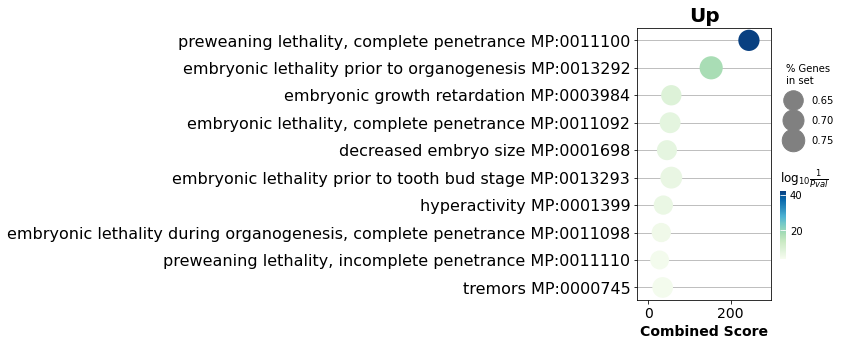

In [71]:
enr_up = gp.enrichr(degs_up.fasting_names,
                    gene_sets='MGI_Mammalian_Phenotype_Level_4_2021',
                    outdir=None)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.GnBu)
plt.savefig('enrich_general_fafe.pdf', bbox_inches="tight")
plt.show()

#### Prediction of activated cell types

fasting vs feeding

In [74]:
cell_types = np.unique(adata_g_full.obs['C185_named_predicted'])
top_iegs = ["Fos","Fosl2","Homer1","Nr4a3","Nr4a1","Gem","Per1","Jun","Junb","Btg1","1700016P03Rik"]
adataq_ff = adata_g_full[(adata_g_full.obs['Condition'] == 'feeding') | (adata_g_full.obs['Condition'] == 'fasting')]
earlyg_mean_p = []
earlyg_mean_p2 = []

In [75]:
for i in range(len(cell_types)):
    print(i)
    adataq_ct_ff = adataq_ff[adataq_ff.obs['C185_named_predicted'] == cell_types[i]]
    
    fedlen = len(adataq_ct_ff[adataq_ct_ff.obs['Condition'] == 'feeding'])
    fastlen = len(adataq_ct_ff[adataq_ct_ff.obs['Condition'] == 'fasting'])
    datlen = adataq_ct_ff.shape[0]
    
    if (fedlen < 1.1) | (fastlen < 1.1) | (datlen == 0):
        earlyg_mean_p.append(0)
        earlyg_mean_p2.append(1)
        continue
    
    sc.tl.rank_genes_groups(adataq_ct_ff, groupby="Condition", use_raw=False, method='wilcoxon', reference='feeding')
    
    result = adataq_ct_ff.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    degs = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
    
    degs_earlyg = degs[degs['fasting_names'].isin(top_iegs)]
    #filtered_degs = degs_earlyg[degs_earlyg['fasting_pvals'] < 0.1]  # Filter observations with p value < 0.05
    #if filtered_degs.shape[0] == 0:
        #earlyg_mean_p.append(0)
        #continue
    
    min_p_index = np.argmin(degs_earlyg['fasting_pvals'].values)
    fold_change_min_p = degs_earlyg.iloc[min_p_index, 4]
    min_p = degs_earlyg.iloc[min_p_index, 2]
    
    #mean_fold_change = np.min(degs_earlyg['logfoldchanges'])
    earlyg_mean_p.append(fold_change_min_p)
    earlyg_mean_p2.append(min_p)

0


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


1


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


3


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


4


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


5


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


6


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


7


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


8


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


9


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


10
11


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


12


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


13
14


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


15


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


16


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


17
18


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


19


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


20
21


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


22
23


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


24
25


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


26


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


27


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


28


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


29


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


30
31


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


32


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


33


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


34


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


35


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


36


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


37


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


38


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


39
40


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


41


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


42


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


43


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


44


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


45
46


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


47


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


48


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


49


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


50


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


51


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


52


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


53


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


54
55


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


56


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


57
58


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


59


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


60
61


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


62


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


63
64


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


65


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


66
67


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


68


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


69


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


70
71
72


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


73
74


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


75


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


76
77


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


78
79


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


80


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


81
82


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


83
84


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


85


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


86
87
88


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


89


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


90


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


91


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


92


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


93


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


94


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


95


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


96


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


97


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


98


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


99


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


100


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


101
102


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


103
104


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


105


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


106


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


107


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


108


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


109


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


110


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


111


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


112


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


113


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


114
115


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


116
117


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


118


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


119


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


120


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


121
122


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


123


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


124


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


125


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


126


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


127


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


128


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


129


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


130


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


131


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


132


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


133


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


134


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


135


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


136


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


137


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


138


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


139
140


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


141


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


142


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


143


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


144


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


145


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


146


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


147


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


148


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


149


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


150


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


151


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


152


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


153


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


154
155


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


156
157


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


158


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


159


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


160
161


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


162


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


163


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


164


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


165


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


166


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


167


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


168


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


169


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


170


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


171


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


172


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


173


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


174


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


175


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


176


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


177


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


178


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


179


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


180


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [76]:
list_ff = pd.DataFrame(earlyg_mean_p, columns=['minp_logfoldchange'])
list_ff['cell_type'] = cell_types
list_ff['min_pval'] = earlyg_mean_p2
list_ff=list_ff.sort_values(by=['minp_logfoldchange'], ascending=False)
list_ff_up = list_ff[list_ff['minp_logfoldchange']>1]
list_ff_down = list_ff[list_ff['minp_logfoldchange']<-1]

In [77]:
list_ff_up_n = list_ff_up[list_ff_up['cell_type'].str.contains('GLU|GABA')]
list_ff_up_n

,minp_logfoldchange,cell_type,min_pval
160,29.815212,C185-81: Tnfrsf12a.GABA-2,0.018589
13,29.114956,C185-112: Meis2.Nts.GABA-1,0.332922
154,27.431761,C185-76: Slc6a3.Onecut2.GABA-2,0.254707
22,26.403429,C185-120: Pou3f1.Sst.GABA-4,0.505723
24,3.252682,C185-122: Satb1.Meis2.GABA-5,0.106509
125,2.385834,C185-49: Glipr1.Pomc.GLU-5,0.120868
128,2.350555,C185-51: Tac2.GLU-5,0.061551
30,2.188567,C185-128: Slc6a3.Satb2.GABA-6,0.117366
25,2.176209,C185-123: Bcl11b.Meis2.GABA-5,0.146312
109,2.050586,C185-34: Sparc.Gpr149.GLU-3,0.506666


In [78]:
list_ff_down_n = list_ff_down[list_ff_down['cell_type'].str.contains('GLU|GABA')]
list_ff_down_n

,minp_logfoldchange,cell_type,min_pval
9,-1.042965,C185-109: Ecel1.Nts.GABA-1,0.464066
120,-1.140821,C185-44: Lpar1.GLU-4,0.266652
101,-1.159287,C185-27: Nts.Cd40.GLU-3,0.258576
104,-1.416109,C185-2: Otx1.GLU-1,0.389642
132,-1.598599,C185-56: Pmch.GLU-7,0.449260
20,-1.850022,C185-119: Nts.Sst.GABA-4,0.089258
127,-2.065602,C185-50: Ttr.Pomc.GLU-5,0.107040
63,-2.172644,C185-15: Ucn3.Trh.GLU-2,0.138873
175,-2.263903,C185-95: Nts.Crh.GABA-1,0.179520
110,-2.571602,C185-35: C1ql2.Gpr149.GLU-3,0.035204


In [79]:
list_ff_up_n.to_csv('/beegfs/home/pmatyskova/singularity/results/scrnaseq/list_ff_up_n.csv', index=False)
list_ff_down_n.to_csv('/beegfs/home/pmatyskova/singularity/results/scrnaseq/list_ff_down_n.csv', index=False)

feeding vs. refeeding

In [7]:
cell_types = np.unique(adata_g_full.obs['C185_named_predicted'])
top_iegs = ["Fos","Fosl2","Homer1","Nr4a3","Nr4a1","Gem","Per1","Jun","Junb","Btg1","1700016P03Rik"]
adataq_fer = adata_g_full[(adata_g_full.obs['Condition'] == 'feeding') | (adata_g_full.obs['Condition'] == 'refed')]
earlyg_mean_p = []
earlyg_mean_p2 = []

In [8]:
for i in range(len(cell_types)):
    print(i)
    adataq_ct_ff = adataq_fer[adataq_fer.obs['C185_named_predicted'] == cell_types[i]]
    
    fedlen = len(adataq_ct_ff[adataq_ct_ff.obs['Condition'] == 'feeding'])
    fastlen = len(adataq_ct_ff[adataq_ct_ff.obs['Condition'] == 'refed'])
    datlen = adataq_ct_ff.shape[0]
    
    if (fedlen < 1.1) | (fastlen < 1.1) | (datlen == 0):
        earlyg_mean_p.append(0)
        earlyg_mean_p2.append(1)
        continue
    
    sc.tl.rank_genes_groups(adataq_ct_ff, groupby="Condition", use_raw=False, method='wilcoxon', reference='refed')
    
    result = adataq_ct_ff.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    degs = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
    
    degs_earlyg = degs[degs['feeding_names'].isin(top_iegs)]
    #filtered_degs = degs_earlyg[degs_earlyg['fasting_pvals'] < 0.1]  # Filter observations with p value < 0.05
    #if filtered_degs.shape[0] == 0:
        #earlyg_mean_p.append(0)
        #continue
    
    min_p_index = np.argmin(degs_earlyg['feeding_pvals'].values)
    fold_change_min_p = degs_earlyg.iloc[min_p_index, 4]
    min_p = degs_earlyg.iloc[min_p_index, 2]
    
    #mean_fold_change = np.min(degs_earlyg['logfoldchanges'])
    earlyg_mean_p.append(fold_change_min_p)
    earlyg_mean_p2.append(min_p)

0


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


1


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


2


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


3


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


4


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


5


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


6


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


7


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


8


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


9


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


10
11


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


12


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


13
14


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


15


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


16


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


17
18


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


19


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


20
21


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


22
23


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


24
25


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


26


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


27


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


28


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


29


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


30


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


31


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


32


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


33


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


34


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


35


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


36


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


37


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


38


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


39
40


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


41


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


42


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


43


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


44


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


45
46


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


47


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


48


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


49


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


50


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


51


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


52


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


53


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


54
55


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


56


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


57
58


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


59


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


60
61


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


62


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


63
64


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


65


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


66
67


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


68


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


69


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


70
71
72


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


73
74


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


75
76


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


77
78
79


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


80


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


81
82


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


83
84


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


85


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


86
87
88


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


89


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


90


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


91


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


92


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


93


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


94


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


95


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


96


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


97


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


98


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


99


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


100


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


101
102


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


103
104


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


105


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


106


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


107


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


108


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


109


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


110


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


111


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


112


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


113


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


114
115


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


116
117


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


118


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


119
120


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


121


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


122
123


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


124


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


125


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


126


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


127


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


128


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


129


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


130


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


131


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


132


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


133


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


134


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


135


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


136


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


137


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


138


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


139
140


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


141


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


142


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


143


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


144


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


145


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


146


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


147


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


148


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


149


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


150


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


151


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


152


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


153


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


154
155


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


156
157


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


158


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


159


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


160
161


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


162


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


163


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


164


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


165


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


166


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


167


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


168


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


169


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


170


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


171


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


172


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


173


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


174


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


175


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


176


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


177


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


178


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


179


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


180


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [9]:
list_ff = pd.DataFrame(earlyg_mean_p, columns=['minp_logfoldchange'])
list_ff['cell_type'] = cell_types
list_ff['min_pval'] = earlyg_mean_p2
list_ff=list_ff.sort_values(by=['minp_logfoldchange'], ascending=False)
list_ff_up = list_ff[list_ff['minp_logfoldchange']>1]
list_ff_down = list_ff[list_ff['minp_logfoldchange']<-1]

In [10]:
list_ff_up_n = list_ff_up[list_ff_up['cell_type'].str.contains('GLU|GABA')]
list_ff_up_n

,minp_logfoldchange,cell_type,min_pval
116,29.738243,C185-40: Adcyap1.GLU-3,0.601508
10,28.301233,C185-10: Adgrf5.Nxph4.GLU-2,0.199165
154,26.112793,C185-76: Slc6a3.Onecut2.GABA-2,0.399998
98,3.729945,C185-24: Mc4r.Fezf1.GLU-3,0.332982
157,3.649719,C185-79: Cd24a.Lhx1.GABA-2,0.395236
110,3.026493,C185-35: C1ql2.Gpr149.GLU-3,0.236125
163,2.623978,C185-84: Epha3.Il1rapl2.GABA-1,0.604557
107,2.611775,C185-32: Bcl11b.Gpr149.GLU-3,0.095418
102,2.454699,C185-28: Cbln4.Cd40.GLU-3,0.322105
3,2.166701,C185-103: Vgll3.Tbx3.GABA-1,0.534643


In [11]:
list_ff_down_n = list_ff_down[list_ff_down['cell_type'].str.contains('GLU|GABA')]
list_ff_down_n

,minp_logfoldchange,cell_type,min_pval
171,-1.007534,C185-91: Gal.Hmcn1.GABA-1,2.768001e-02
144,-1.036984,C185-67: Pnoc.Mixed.GABA-2,5.302784e-01
33,-1.038198,C185-130: Chat.GABA-7,6.515416e-02
31,-1.060789,C185-129: Nr5a2.Satb2.GABA-6,1.652676e-01
148,-1.069920,C185-70: Otx2.Mixed.GABA-2,1.967887e-01
174,-1.071816,C185-94: Gal.Crh.GABA-1,1.081996e-01
28,-1.119226,C185-126: Tac1.Meis2.GABA-5,2.505021e-01
164,-1.119586,C185-85: Pthlh.Il1rapl2.GABA-1,9.644163e-02
167,-1.122078,C185-88: Sox14.Lef1.GABA-1,6.531167e-02
117,-1.151496,C185-41: Lef1.Mixed.GLU-4,5.376839e-03


In [85]:
list_ff_up_n.to_csv('/beegfs/home/pmatyskova/singularity/results/scrnaseq/list_fer_up_n.csv', index=False)
list_ff_down_n.to_csv('/beegfs/home/pmatyskova/singularity/results/scrnaseq/list_fer_down_n.csv', index=False)

#### Differential gene expression and enrichment per cell type

In [465]:
adataq_ff = adata_g_full[(adata_g_full.obs['Condition'] == 'feeding') | (adata_g_full.obs['Condition'] == 'refed')]
adataq_ct_ff = adataq_ff[adataq_ff.obs['C185_named_predicted'] == 'C185-50: Ttr.Pomc.GLU-5']
sc.tl.rank_genes_groups(adataq_ct_ff, groupby="Condition", use_raw=False, method='wilcoxon', reference='refed')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [466]:
result = adataq_ct_ff.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [467]:
degs = degs[(degs['pvals']<0.05)]

In [468]:
top5_up = degs.nlargest(5, 'logfoldchanges')
top5_dw = degs.nsmallest(5, 'logfoldchanges')
top5_dw = top5_dw[::-1]
top10 = pd.concat([top5_up, top5_dw])

In [469]:
sns.heatmap(np.reshape(top10['logfoldchanges'].values,[1,10]),linewidth=0.2,linecolor='black',
            vmin=-5, vmax=5,
            xticklabels=top10['names'], cmap=plt.cm.GnBu, square=True, cbar=True, cbar_kws={'shrink': .5})
plt.yticks(ticks=np.arange(1) + 0.5, labels=['C185-50: Ttr.Pomc.GLU-5'], rotation='vertical')
plt.title('feeding vs. refed')
plt.tight_layout()
plt.savefig('/beegfs/home/pmatyskova/singularity/results/scrnaseq/fere_ttrpomc.pdf')
plt.close()

In [234]:
adataq_ff = adata_g_full[(adata_g_full.obs['Condition'] == 'feeding') | (adata_g_full.obs['Condition'] == 'refed')]
adataq_ct_ff = adataq_ff[adataq_ff.obs['C185_named_predicted'] == 'C185-114: Ghrh.GABA-3']
sc.tl.rank_genes_groups(adataq_ct_ff, groupby="Condition", use_raw=False, method='wilcoxon', reference='refed')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [235]:
result = adataq_ct_ff.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [244]:
degs_sig = degs[degs.pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.logfoldchanges < 0]

In [245]:
degs_dw

,names,scores,pvals,pvals_adj,logfoldchanges
28426,Osbpl6,-4.353417,1.340317e-05,0.042336,-0.836582
28427,AC149090.1,-5.535032,3.111717e-08,0.000885,-1.164091


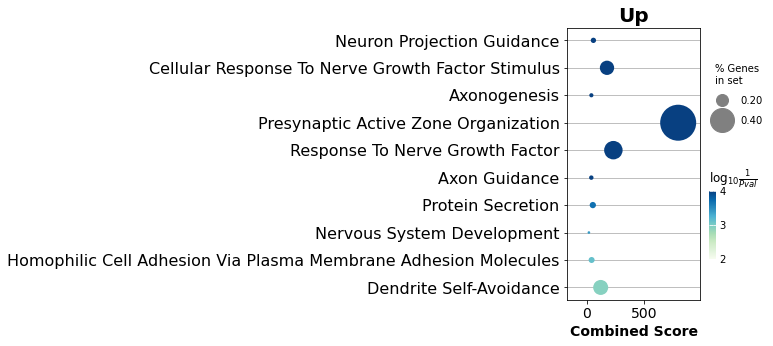

In [238]:
enr_up = gp.enrichr(degs_up.names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.GnBu, size = 10, 
           column = "P-value", cutoff = 0.05)
#plt.savefig('enrich_ntscrh_fafe.pdf', bbox_inches="tight")
plt.show()

In [239]:
enr_dw = gp.enrichr(degs_dw.names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)

In [240]:
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(), enr_dw.res2d.head()])

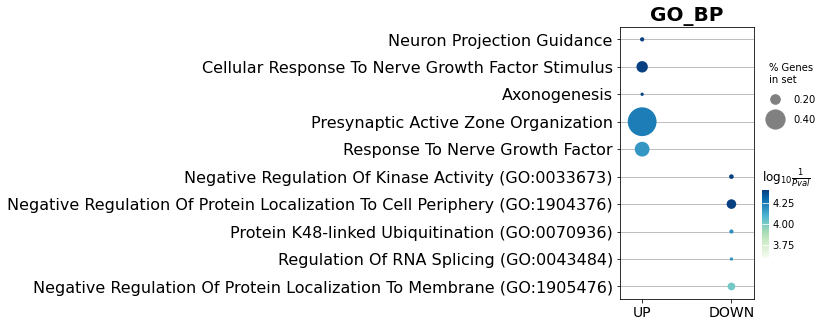

In [243]:
ax = gp.dotplot(enr_res,figsize=(3,5), x='UP_DW', x_order = ["UP","DOWN"], title="GO_BP",
                cmap = plt.cm.GnBu, size=8, column = "P-value", cutoff = 0.05)
ax.set_xlabel("")
#plt.savefig('enrich_ghrh_fere.pdf', bbox_inches="tight")
plt.show()